# Gaussian Process model

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from scipy.spatial.distance import cdist

In [2]:
x_linspace = np.linspace(-3.2,3.2,100)
x_training = np.array([-3,-1.5,0,1.5,2.5,2.7])
y_training = np.sin(x_training)

## Defing the kernel function

In [3]:
def squared_exponetial_kernel(x1,x2):
    if x1.ndim == 1 and x2.ndim == 1:
        x1 = x1.reshape(-1,1)
        x2 = x2.reshape(-1,1)
    from scipy.spatial.distance import cdist
    dx = cdist(x1,x2) #求欧几里得距离
    return np.exp(-dx ** 2 / 2)

## 预测并计算误差

In [4]:
x_testing = np.linspace(-3.2,3.2,30)
y_testing = np.sin(x_testing)
K = squared_exponetial_kernel(x_training,x_training)
K_star = squared_exponetial_kernel(x_testing,x_training)
y_predict = K_star.dot(np.linalg.inv(K)).dot(y_training)

### 展示

MSE = 0.002671251640256426


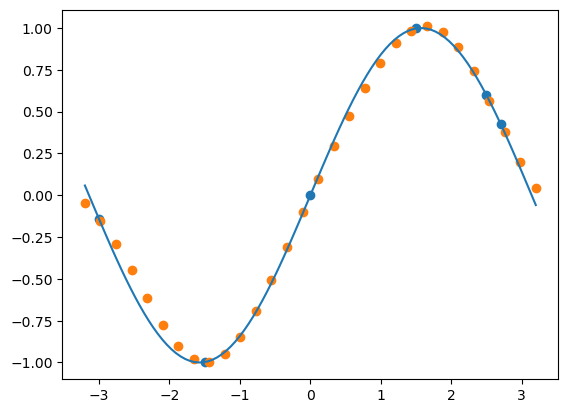

In [5]:
plt.plot(x_linspace,np.sin(x_linspace))
plt.scatter(x_training,y_training)
plt.scatter(x_testing,y_predict)
plt.show
MSE = np.mean((y_predict-y_testing)**2)
print(f'MSE = {MSE}')

# Gaussian process regression

## derivation

### tensorflow method

In [6]:
def tf_derivation(X,params,t):
    D = len(params)
    p0 = tf.Variable(params[0], dtype=tf.float32)
    p1 = tf.Variable(params[1], dtype=tf.float32)
    p2 = tf.Variable(params[2], dtype=tf.float32)
    p3 = tf.Variable(params[3], dtype=tf.float32)
    p4 = tf.Variable(params[4], dtype=tf.float32)
    p5 = tf.Variable(params[5], dtype=tf.float32)
    p6 = tf.Variable(params[6], dtype=tf.float32)
    p7 = tf.Variable(params[7], dtype=tf.float32)
    p8 = tf.Variable(params[8], dtype=tf.float32)
    p9 = tf.Variable(params[9], dtype=tf.float32)
    p10 = tf.Variable(params[10], dtype=tf.float32)
    p11 = tf.Variable(params[11], dtype=tf.float32)
    p12 = tf.Variable(params[12], dtype=tf.float32)
    pn = tf.Variable(params[D], dtype=tf.float32)
    with tf.GradientTape() as tape:
        I = np.eye(len(X))
        X = tf.cast(X, dtype=tf.float32)
        d = (p1 + p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9 + p10 + p11 + p12) * cdist(X,X.T)**2
        Gram = p0 * np.exp(-0.5 * d) + pn * I
        precision = tf.linalg.inv(Gram)
        log_like =-0.5 * (tf.linalg.slogdet(Gram)[1] + t.T @ precision @ t + len(t) * np.log(2 * np.pi))
        g = tape.gradient(log_like,[p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, pn])
    return np.array([i.numpy() for i in g])

# stochastic gradient desent
def kernels(x,y,params = None,pw = True):
    params_dist = sum(params[1:len(params)-1])
    d = params_dist * cdist(x,y)**2
    k = params[0] * np.exp(-0.5 * d)
    return k 

def get_precision(X,params):
    I = np.eye(len(X))
    Gram = kernels(X, X.T, params)
    covariance = Gram +  params[len(params)] * I 
    precision = np.linalg.inv(covariance)
    return covariance, precision

def log_likelihood(covariance, t, precision):
    return -0.5 * (
            np.linalg.slogdet(covariance)[1]
            + t.T @ precision @ t
            + len(t) * np.log(2 * np.pi))

def gpr(X, t, params, iter_max, learning_rate):
    log_likelihood_list = [-np.Inf]
    for i in range(iter_max):
        updates = tf_derivation(X, params, t)
        for j in range(iter_max):
            params += learning_rate * updates
            covariance, precision = get_precision(X, params)
            log_like = log_likelihood(covariance, t, precision)
            if log_like > log_likelihood_list[-1]:
                log_likelihood_list.append(log_like)
                break
            else:
                params += -learning_rate * updates
                learning_rate *= 0.9
    log_likelihood_list.pop(0)#删除第一个数
    return log_likelihood_list, params

### Prediction

In [7]:
def predict(X, Xs, t, params):
    _, precision = get_precision(X, params)
    KK = [kernels(X, pre, params, pw=False) for pre in Xs]
    mean = np.array([K.T @ precision @ t for K in KK]).reshape(len(Xs),)
    var = np.array([kernels(pre, pre, params, pw=False) for pre in Xs]) + 1 / beta - \
          np.array([K.T @ precision @ K for K in KK]).reshape(len(Xs),)
    return mean, np.sqrt(var)

In [8]:
def create_toy_data(func, n=10, std=1., domain='0 1'):
    xdim = [float(domain.split(' ')[0]), float(domain.split(' ')[1])]
    x = np.linspace(xdim[0], xdim[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    x = x.reshape(n, 1)
    t = t.reshape(n, 1)
    return x, t
"""
x_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain='0. 1.')
x = np.linspace(0, 1, 100)  # 测试集
INIT_PARAMS = np.array([1.0, 1.0, 1.0, 1.0])
ITER_MAX = 50
LEARNING_RATE = 0.1
llike, positer_params = gpr(x_train, y_train, INIT_PARAMS, ITER_MAX, LEARNING_RATE)
y, y_std = predict(x_train, x, y_train, positer_params)

"""

"\nx_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain='0. 1.')\nx = np.linspace(0, 1, 100)  # 测试集\nINIT_PARAMS = np.array([1.0, 1.0, 1.0, 1.0])\nITER_MAX = 50\nLEARNING_RATE = 0.1\nllike, positer_params = gpr(x_train, y_train, INIT_PARAMS, ITER_MAX, LEARNING_RATE)\ny, y_std = predict(x_train, x, y_train, positer_params)\n\n"

In [9]:
from scipy.optimize import minimize